<h1>Mineria de datos y modelizacion predictiva 3 - Tarea</h1>

Librerias usadas

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from tabulate import tabulate

<h2>1 - Presentación de la serie</h2>

La serie con la que vamos a trabajar es un serie obtenida por el Servicio Meteorolgico Nacional de la Republica Argentina que tiene todos los registros temperatura maxima y minima para todas las ciudad del pais correspondiente a los ultimos 365 dias.

El dataset original se adjunta con el nombre original "registro_temperatura365d_smn.txt". 

Fuente: https://datos.gob.ar/dataset/smn-registro-temperatura-365-dias

Para poder trabajar con datos mas reducidos y cumplir con la consigna voy a trabajar con los datos de la ciudad donde vivo, Rosario, y solo con las TEMERATURAS MAXIMAS dejando de lado las minimas.

Uso el naming convention bronze, silver, gold para nombrar los diferentes conjuntos de datos segun la madurez de los mismos. Esta convencion es sacada del patron Medallion el cual es un patron de diseño para manipulacion de datos. Bronze son los datos como vienen de origen, Silver son datos filtrados y limpiados, gold son los datos finales que pueden tener transformacion de tipos de datos asi como agregados definidos por el nivel de Negocios. 
Referencia: https://www.databricks.com/glossary/medallion-architecture

Text(0.5, 1.0, 'Tempraturas máximas - Rosario (Arg)')

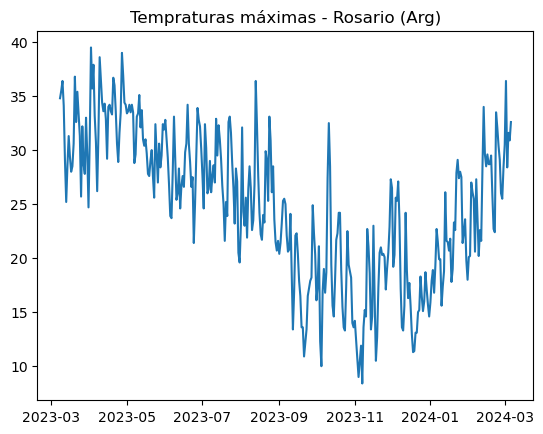

In [ ]:
with open("registro_temperatura365d_smn.txt", "r", encoding="latin1") as f:
    bronze_data = f.read()

lines = bronze_data.strip().split("\n")[2:] 
rosario_temps = [line.split()[1] for line in lines if "ROSARIO" in line] 

max_temps = []
for temp in rosario_temps:
    try:
        max_temps.append(float(temp))
    except ValueError:
        max_temps.append(None) 

silver_dates = pd.date_range(start="2023-03-08", periods=len(max_temps))

gold_rosario_temperature_series = pd.Series(max_temps, index=silver_dates)

plt.plot(gold_rosario_temperature_series)
plt.title('Tempraturas máximas en C° - Rosario (Arg)')




<h2>2 - Representación gráfica y descomposición estacional</h2>

Vamos a proceder a hacer la descomposición de la serie. El valor mínimo observado es 8.4 C° por lo que podemos usar una descomposición multiplicativa ya que no tenemos valores negativos o 0.

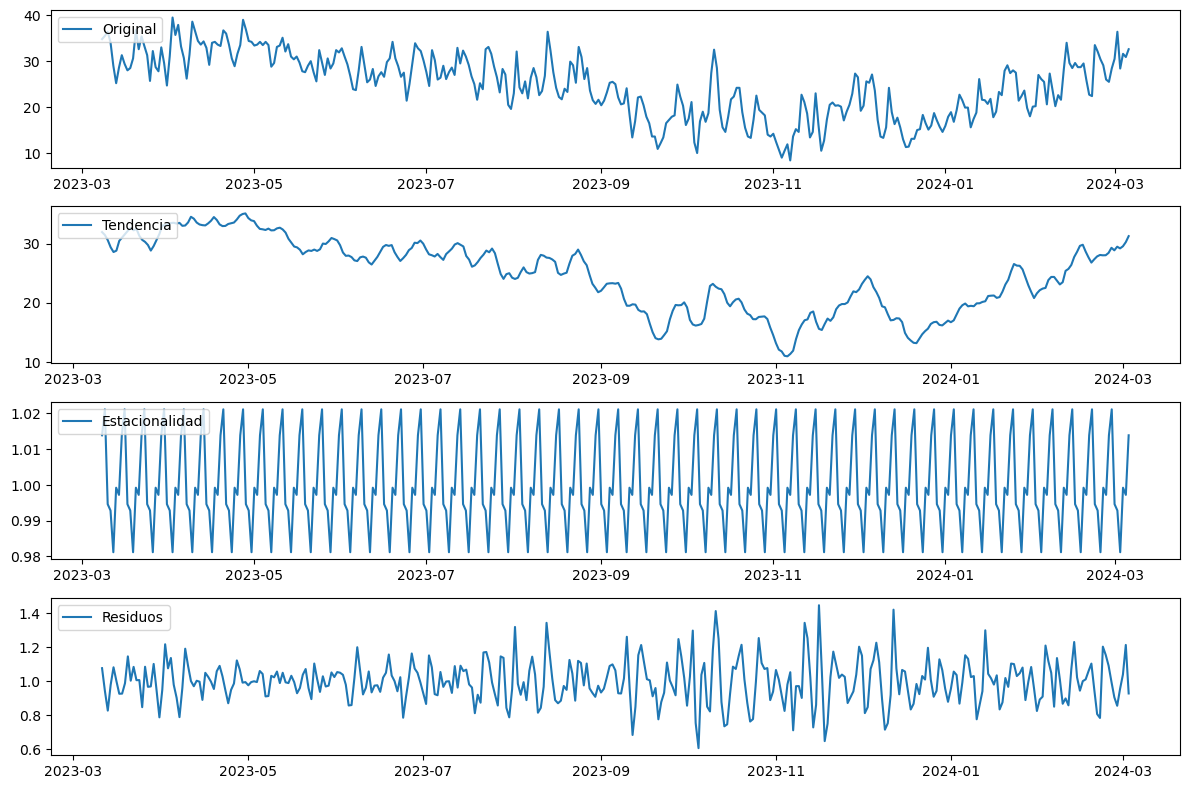

In [14]:
def decompose_time_series(time_series):
    decomposition = seasonal_decompose(time_series, model='multiplicative')
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(time_series, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Tendencia')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal, label='Estacionalidad')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuos')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

decompose_time_series(gold_rosario_temperature_series)

<h2>3 - Muestras de Train y Test</h2>

Vamos a dividir nuestro conjunto de datos con la serie en dos subconjuntos de train y test. Reservo el 10% de las observaciones para pruebas quedandome con el 90% para entrenamiento

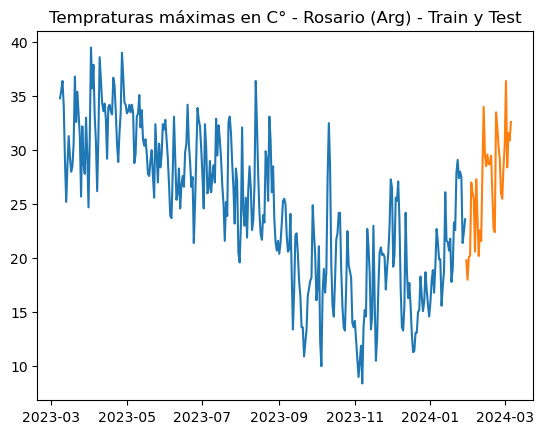

In [17]:

def split_train_test(time_series, test_size):
    split_index = int(len(time_series) * (1 - test_size))
    train = time_series[:split_index]
    test = time_series[split_index:]
    return train, test

gold_rosario_temperature_train, gold_rosario_temperature_test= split_train_test(gold_rosario_temperature_series,0.1)

plt.plot(gold_rosario_temperature_train)
plt.title('Tempraturas máximas en C° - Rosario (Arg) - Train y Test')

plt.plot(gold_rosario_temperature_test)



<h2>4 - Suavizado Exponencial</h2>

Vamos a proceder a realizar las diferentes tecnicas de suavizado exponenciales dados en clase a saber:

<li> Metodo exponencial simple
<li> Metodo de alisado doble de halt
<li> Metodo de tendencia amortiguada de Halt
<li> Método de Holt-Winters

In [48]:
def simple_exp_smoothing_forecast(time_series_train, time_series_test, alpha=0.2):
    model = SimpleExpSmoothing(time_series_train).fit(smoothing_level=alpha, optimized=True)
    forecast = model.forecast(steps=len(time_series_test))
    return model.fittedvalues, forecast

def holt_trend_smoothing_forecast(time_series_train, time_series_test, alpha=0.2, beta=0.1):
    model = Holt(time_series_train).fit(smoothing_level=alpha, smoothing_trend=beta, optimized=True)
    forecast = model.forecast(steps=len(time_series_test))
    return model.fittedvalues, forecast

def holt_trend_damped_smoothing_forecast(time_series_train, time_series_test, alpha=0.2, beta=0.1):
    model = Holt(time_series_train, damped_trend = True).fit(smoothing_level=alpha, smoothing_trend=beta, optimized=True)
    forecast = model.forecast(steps=len(time_series_test))
    return model.fittedvalues, forecast


def holt_winters_smoothing_forecast(time_series_train, time_series_test, seasonal_periods, trend='add', seasonal='add'):
    model = ExponentialSmoothing(time_series_train, seasonal_periods=seasonal_periods, trend=trend, seasonal=seasonal).fit()
    forecast = model.forecast(steps=len(time_series_test))
    return model.fittedvalues, forecast

simple_fitted, simple_forecast = simple_exp_smoothing_forecast(gold_rosario_temperature_train, gold_rosario_temperature_test)
holt_fitted, holt_forecast = holt_trend_smoothing_forecast(gold_rosario_temperature_train, gold_rosario_temperature_test)
holt_damped_fitted, holt_damped_forecast = holt_trend_damped_smoothing_forecast(gold_rosario_temperature_train, gold_rosario_temperature_test)
holt_winters_fitted, holt_winters_forecast = holt_winters_smoothing_forecast(gold_rosario_temperature_train, gold_rosario_temperature_test, seasonal_periods=12)


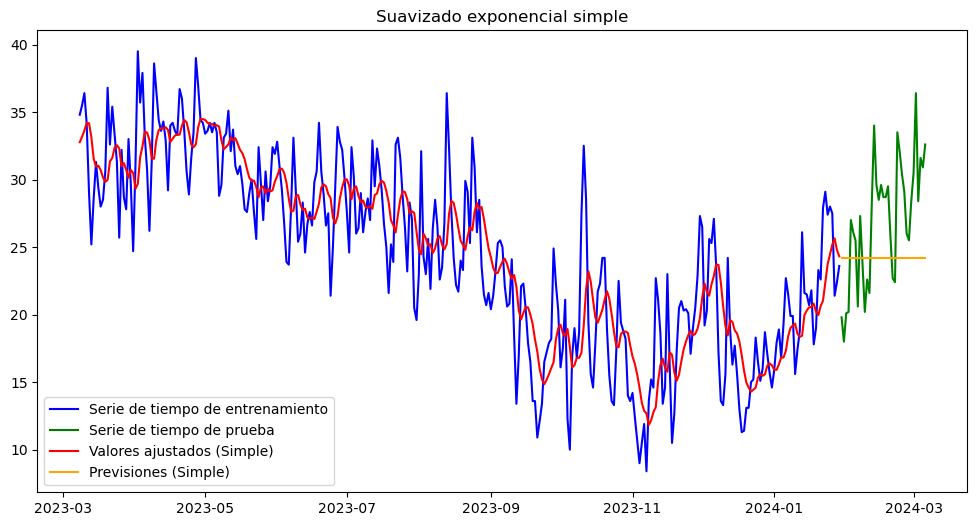

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(gold_rosario_temperature_train, label='Serie de tiempo de entrenamiento', color='blue')
plt.plot(gold_rosario_temperature_test, label='Serie de tiempo de prueba', color='green')
plt.plot(gold_rosario_temperature_train.index, simple_fitted, label='Valores ajustados (Simple)', color='red')
plt.plot(gold_rosario_temperature_test.index, simple_forecast, label='Previsiones (Simple)', color='orange')
plt.title('Suavizado exponencial simple')
plt.legend()
plt.show()

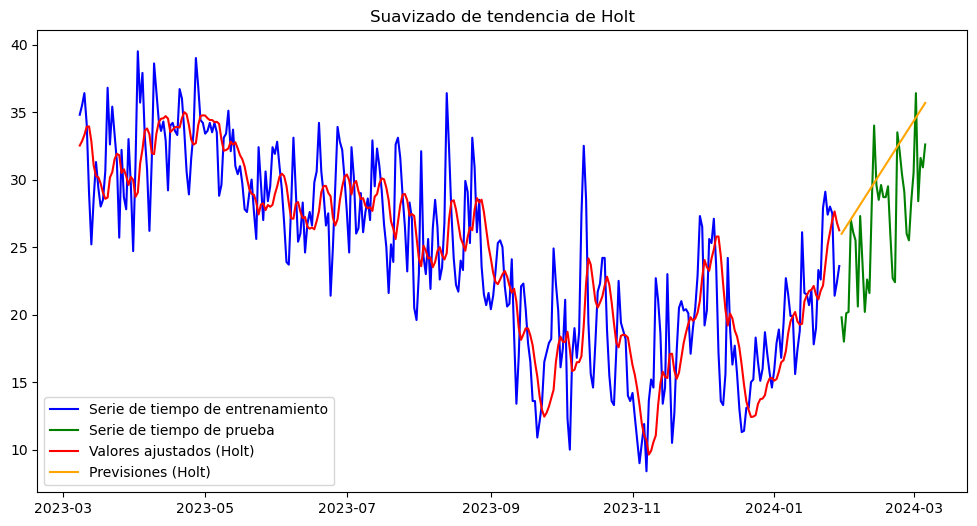

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(gold_rosario_temperature_train, label='Serie de tiempo de entrenamiento', color='blue')
plt.plot(gold_rosario_temperature_test, label='Serie de tiempo de prueba', color='green')
plt.plot(gold_rosario_temperature_train.index, holt_fitted, label='Valores ajustados (Holt)', color='red')
plt.plot(gold_rosario_temperature_test.index, holt_forecast, label='Previsiones (Holt)', color='orange')
plt.title('Suavizado de tendencia de Holt')
plt.legend()
plt.show()

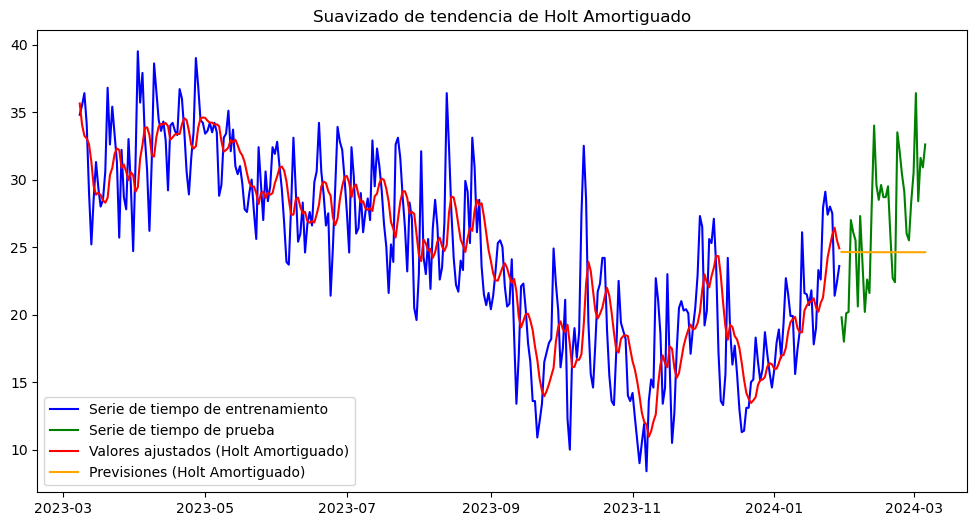

In [51]:

plt.figure(figsize=(12, 6))
plt.plot(gold_rosario_temperature_train, label='Serie de tiempo de entrenamiento', color='blue')
plt.plot(gold_rosario_temperature_test, label='Serie de tiempo de prueba', color='green')
plt.plot(gold_rosario_temperature_train.index, holt_damped_fitted, label='Valores ajustados (Holt Amortiguado)', color='red')
plt.plot(gold_rosario_temperature_test.index, holt_damped_forecast, label='Previsiones (Holt Amortiguado)', color='orange')
plt.title('Suavizado de tendencia de Holt Amortiguado')
plt.legend()
plt.show()

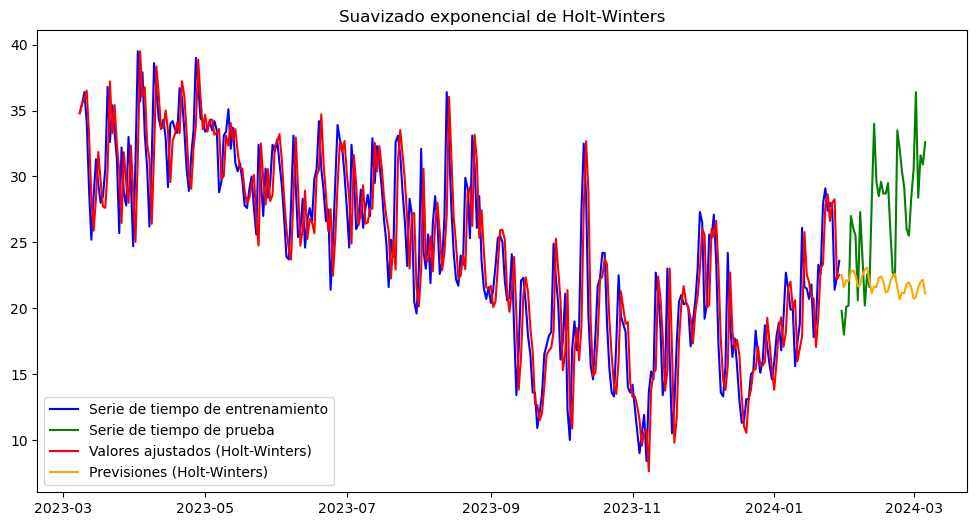

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(gold_rosario_temperature_train, label='Serie de tiempo de entrenamiento', color='blue')
plt.plot(gold_rosario_temperature_test, label='Serie de tiempo de prueba', color='green')
plt.plot(gold_rosario_temperature_train.index, holt_winters_fitted, label='Valores ajustados (Holt-Winters)', color='red')
plt.plot(gold_rosario_temperature_test.index, holt_winters_forecast, label='Previsiones (Holt-Winters)', color='orange')
plt.title('Suavizado exponencial de Holt-Winters')
plt.legend()
plt.show()

In [38]:
comparison_table = pd.DataFrame({
    'Valor Real': gold_rosario_temperature_test,
    'Simple Smoothing Forecast': simple_forecast,
    'Holt Smoothing Forecast': holt_forecast,
    'Holt-Winters Smoothing Forecast': holt_winters_forecast
})

print(tabulate(comparison_table, headers='keys', tablefmt='psql'))

+---------------------+--------------+-----------------------------+---------------------------+-----------------------------------+
|                     |   Valor Real |   Simple Smoothing Forecast |   Holt Smoothing Forecast |   Holt-Winters Smoothing Forecast |
|---------------------+--------------+-----------------------------+---------------------------+-----------------------------------|
| 2024-01-30 00:00:00 |         19.8 |                     24.1726 |                   25.9845 |                           22.5076 |
| 2024-01-31 00:00:00 |         18   |                     24.1726 |                   26.2537 |                           21.6042 |
| 2024-02-01 00:00:00 |         20.1 |                     24.1726 |                   26.5228 |                           22.1188 |
| 2024-02-02 00:00:00 |         20.2 |                     24.1726 |                   26.792  |                           22.0633 |
| 2024-02-03 00:00:00 |         27   |                     24.1726 | 